# KNN Image Classifier

## Import Libraries

In [1]:
import os
import numpy as np
from PIL import Image
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split
from skimage.color import rgb2gray
from skimage.filters import sobel
from skimage import exposure
from skimage.feature import graycomatrix, graycoprops
import matplotlib.pyplot as plt
from scipy.ndimage import shift

def pad_array(arr, n):
    #if len(arr) >= n:
        #return arr[:n]  # Trim the array if it's longer than n
    #else:
    pad_width = (0, n - len(arr))  # Calculate the padding width
    return np.pad(arr, pad_width, mode='constant', constant_values=0)

def extract_features(image, output_folder, file_name):
    # Convert the image to grayscale
    gray_image = rgb2gray(image)
    
    # Convert the image to unsigned integer type
    gray_image = (gray_image * 255).astype(np.uint8)
    
    # Save the grayscale image
    grayscale_path = os.path.join(output_folder, file_name+'grayscale.png')
    plt.imsave(grayscale_path, gray_image, cmap='gray')
    
    # Extract edge features using Sobel filter
    edge_features = sobel(gray_image)
    
    # Save the edge features image
    edge_path = os.path.join(output_folder, file_name+'edge_features.png')
    plt.imsave(edge_path, edge_features, cmap='gray')
    
    # Calculate histogram features
    hist, _ = exposure.histogram(gray_image, nbins=256)
    
    # Calculate texture features using GLCM (Grey-Level Co-occurrence Matrix)
    glcm = graycomatrix(gray_image, [5], [0], 256, symmetric=True, normed=True)
    contrast = graycoprops(glcm, 'contrast')[0, 0]
    energy = graycoprops(glcm, 'energy')[0, 0]
    correlation = graycoprops(glcm, 'correlation')[0, 0]

    # Save the histogram features plot
    hist_path = os.path.join(output_folder, file_name+'histogram.png')
    plt.plot(hist)
    plt.xlabel('Intensity')
    plt.ylabel('Frequency')
    plt.savefig(hist_path)
    plt.close()
    
    # Extract shift features
    shifted_image_1 = shift(gray_image, (10, 10))
    shifted_image_2 = shift(gray_image, (-10, -10))

    # Save the shifted images
#     shifted_image_1_path = os.path.join(output_folder, file_name+'shifted_image_1.png')
#     shifted_image_2_path = os.path.join(output_folder, file_name+'shifted_image_2.png')
#     plt.imsave(shifted_image_1_path, shifted_image_1, cmap='gray')
#     plt.imsave(shifted_image_2_path, shifted_image_2, cmap='gray')
    
    # Concatenate all features into a single feature vector
    features = np.concatenate([edge_features.flatten(), hist, [contrast, energy, correlation]])
    
    return features

## Data Preprocessing

In [9]:
# Set the path to the image folders
folder_path = 'data/images/'
output_folder = 'data/results/'

# Set the target image size
target_size = (256, 256)  # Adjust this as needed

# Load the image data and labels
X = []
y = []
class_labels = ['cassava', 'maize', 'banana', 'weed']
#class_labels=['x']
for label in class_labels:
    folder = os.path.join(folder_path, label)
    images = os.listdir(folder)
    for image_file in images:
        img_path = os.path.join(folder, image_file)
        img = Image.open(img_path)
        img = img.convert('RGB')  # Convert to RGB if needed
        img = img.resize(target_size)  # Resize the image
        
        # Extract the features from the image
        img_features = extract_features(np.array(img), output_folder, label+image_file)
        flattened_img_features = pad_array(img_features.flatten(), 70000)
        
        #print(len(flattened_img_features))
        
        #img_array = np.array(img)
        #X.append(img_array.flatten())  # Flatten the image to a 1D vector
        X.append(flattened_img_features)
        y.append(label)
        #break
    #break

# Convert data to NumPy arrays
X = np.array(X)
y = np.array(y)

In [10]:
print(X.shape)

(133, 70000)


In [11]:

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the Naive Bayes classifier
model = GaussianNB()
model.fit(X_train.reshape(X_train.shape[0], -1), y_train)
#model.fit(X_train, y_train)

# Predict the labels for the test set
y_pred = model.predict(X_test.reshape(X_test.shape[0], -1))
#y_pred = model.predict(X_test)



## Evaluate Model

In [13]:
from sklearn.metrics import classification_report, accuracy_score
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
classification_report = classification_report(y_test, y_pred, zero_division=1)

# Print the results
print("Accuracy:", accuracy)
print("Classification Report:")
print(classification_report)

Accuracy: 0.7037037037037037
Classification Report:
              precision    recall  f1-score   support

      banana       1.00      0.00      0.00         2
     cassava       0.70      0.93      0.80        15
       maize       0.80      0.57      0.67         7
        weed       0.50      0.33      0.40         3

    accuracy                           0.70        27
   macro avg       0.75      0.46      0.47        27
weighted avg       0.73      0.70      0.66        27



# EVALUATE KNN MODEL

In [14]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score
# Create and train the KNN classifier
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

# Predict the labels for the test set
y_pred = knn.predict(X_test)

# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
classification_report = classification_report(y_test, y_pred, zero_division=1)
print("Classification Report:")
print(classification_report)

Accuracy: 0.7037037037037037
Classification Report:
              precision    recall  f1-score   support

      banana       0.00      0.00      0.00         2
     cassava       0.72      0.87      0.79        15
       maize       0.75      0.86      0.80         7
        weed       1.00      0.00      0.00         3

    accuracy                           0.70        27
   macro avg       0.62      0.43      0.40        27
weighted avg       0.71      0.70      0.65        27



C:\Users\josep\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\josep\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\josep\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1344

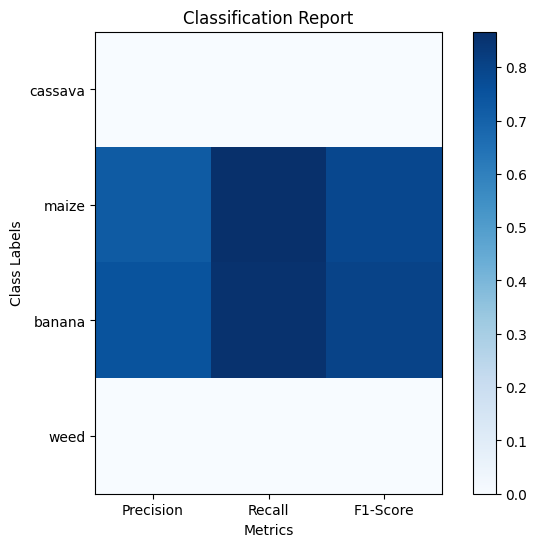

In [16]:
from sklearn.metrics import classification_report, accuracy_score
# Generate classification report
report = classification_report(y_test, y_pred, target_names=class_labels, output_dict=True)

# Plot classification report
plt.figure(figsize=(8, 6))
plt.imshow([[report[label][metric] for metric in ['precision', 'recall', 'f1-score']] for label in class_labels], cmap='Blues')

plt.title('Classification Report')
plt.xlabel('Metrics')
plt.ylabel('Class Labels')
plt.xticks(range(3), ['Precision', 'Recall', 'F1-Score'])
plt.yticks(range(len(class_labels)), class_labels)
plt.colorbar()
plt.show()

In [9]:
import matplotlib.pyplot as plt

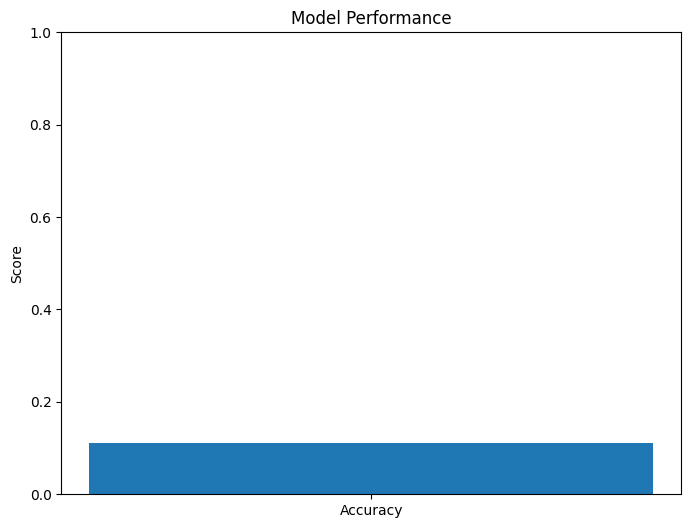

In [7]:
# Define the performance metrics
labels = ['Accuracy']
scores = [accuracy]

# Plot the performance
plt.figure(figsize=(8, 6))
plt.bar(labels, scores)
plt.ylim([0, 1])  # Set the y-axis limits
plt.ylabel('Score')
plt.title('Model Performance')
plt.show()

ValueError: The number of FixedLocator locations (2), usually from a call to set_ticks, does not match the number of labels (4).

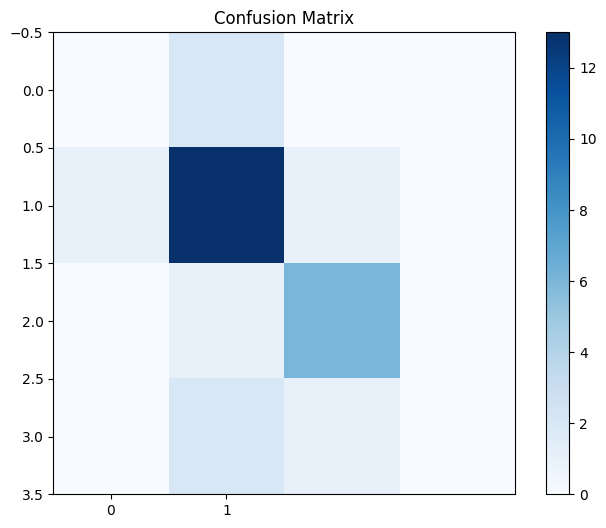

In [18]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, precision_recall_curve, confusion_matrix

# Predict the probabilities for the test set
y_pred_prob = knn.predict_proba(X_test)



# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)



# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
plt.imshow(cm, cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xticks([0, 1], class_labels)
plt.yticks([0, 1], class_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

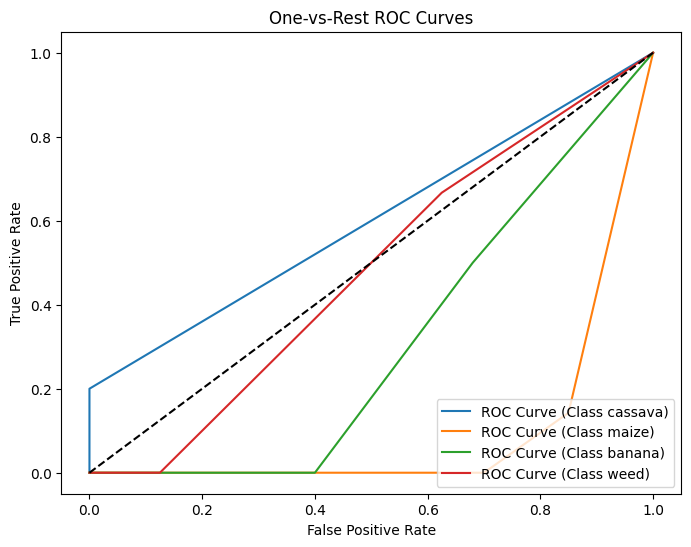

In [19]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Compute One-vs-Rest ROC curve for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(len(class_labels)):
    fpr[i], tpr[i], _ = roc_curve(y_test, y_pred_prob[:, i], pos_label=class_labels[i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot One-vs-Rest ROC curves
plt.figure(figsize=(8, 6))
for i in range(len(class_labels)):
    plt.plot(fpr[i], tpr[i], label='ROC Curve (Class {})'.format(class_labels[i]))

plt.plot([0, 1], [0, 1], linestyle='--', color='black')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('One-vs-Rest ROC Curves')
plt.legend(loc='lower right')
plt.show()

# DEEP LEARNING MODEL

In [23]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Convert labels to numerical values
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Normalize the input data
X_train = X_train / 255.0
X_test = X_test / 255.0

# Define the TensorFlow model architecture
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(X.shape[1],)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(len(class_labels), activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [25]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 64)                4480064   
                                                                 
 dense_4 (Dense)             (None, 32)                2080      
                                                                 
 dense_5 (Dense)             (None, 4)                 132       
                                                                 
Total params: 4,482,276
Trainable params: 4,482,276
Non-trainable params: 0
_________________________________________________________________


In [29]:
# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/10
4/4 [==============================] - 1s 148ms/step - loss: 0.4790 - accuracy: 0.8585 - val_loss: 0.6042 - val_accuracy: 0.8148
Epoch 2/10
4/4 [==============================] - 1s 131ms/step - loss: 0.4518 - accuracy: 0.8585 - val_loss: 0.6472 - val_accuracy: 0.8148
Epoch 3/10
4/4 [==============================] - 0s 116ms/step - loss: 0.4322 - accuracy: 0.8868 - val_loss: 0.5919 - val_accuracy: 0.8519
Epoch 4/10
4/4 [==============================] - 0s 111ms/step - loss: 0.3847 - accuracy: 0.9151 - val_loss: 0.5936 - val_accuracy: 0.8519
Epoch 5/10
4/4 [==============================] - 0s 115ms/step - loss: 0.3777 - accuracy: 0.8962 - val_loss: 0.5926 - val_accuracy: 0.8148
Epoch 6/10
4/4 [==============================] - 0s 110ms/step - loss: 0.3453 - accuracy: 0.9340 - val_loss: 0.5980 - val_accuracy: 0.7778
Epoch 7/10
4/4 [==============================] - 0s 120ms/step - loss: 0.3247 - accuracy: 0.9245 - val_loss: 0.5738 - val_accuracy: 0.8519
Epoch 8/10
4/4 [====

## Plot Performance

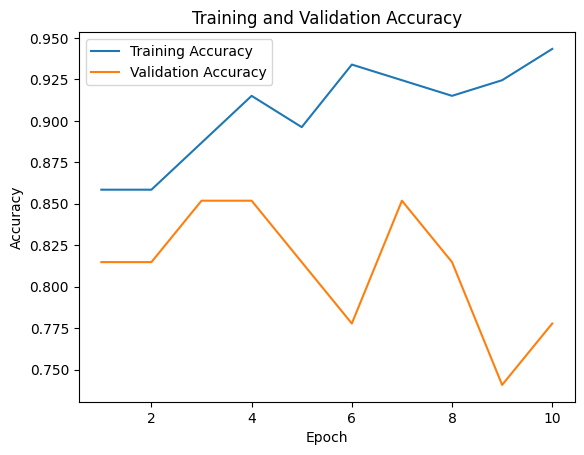

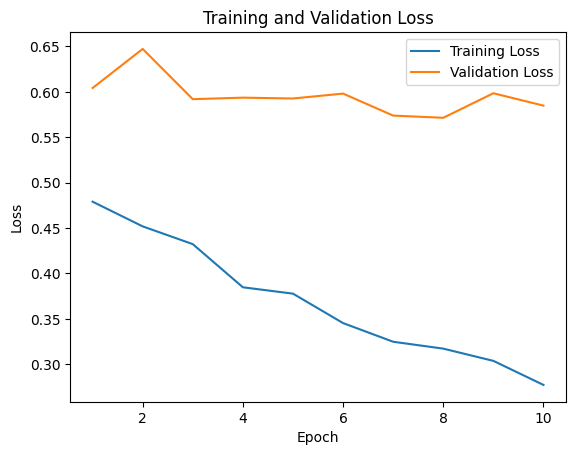

In [33]:
# Retrieve the training accuracy, loss, validation accuracy, and validation loss
accuracy = history.history['accuracy']
loss = history.history['loss']
val_accuracy = history.history['val_accuracy']
val_loss = history.history['val_loss']

# Plotting the accuracy
plt.plot(range(1, len(accuracy) + 1), accuracy, label='Training Accuracy')
plt.plot(range(1, len(val_accuracy) + 1), val_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

# Plotting the loss
plt.plot(range(1, len(loss) + 1), loss, label='Training Loss')
plt.plot(range(1, len(val_loss) + 1), val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

## Plot a confusion matrix based on the predictions made by the model,

In [34]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

1/1 [==============================] - 0s 71ms/step


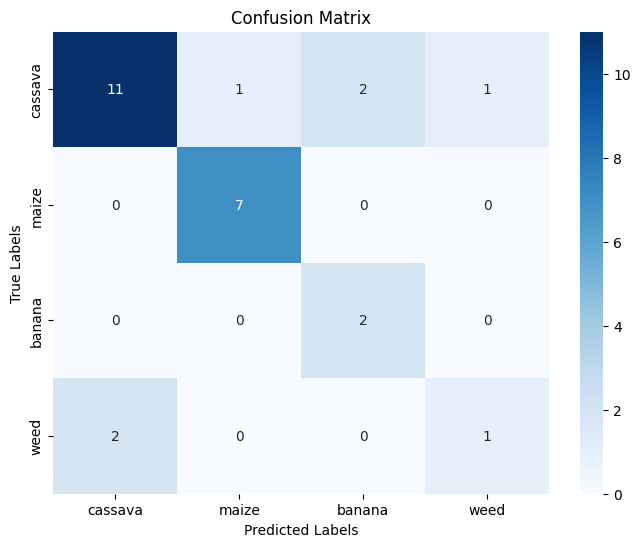

In [40]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Make predictions on the test set
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

# Convert the encoded labels back to their original labels
y_test_labels = label_encoder.inverse_transform(y_test)
y_pred_labels = label_encoder.inverse_transform(y_pred)

# Compute the confusion matrix
cm = confusion_matrix(y_test_labels, y_pred_labels, labels=class_labels)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [41]:
print(cm)

[[11  1  2  1]
 [ 0  7  0  0]
 [ 0  0  2  0]
 [ 2  0  0  1]]


## plot accuracy, recall, and F1 score based on the predictions made by the model

In [42]:
from sklearn.metrics import accuracy_score, recall_score, f1_score

Accuracy: 0.7777777777777778
Recall: 0.7777777777777778
F1: 0.772310405643739


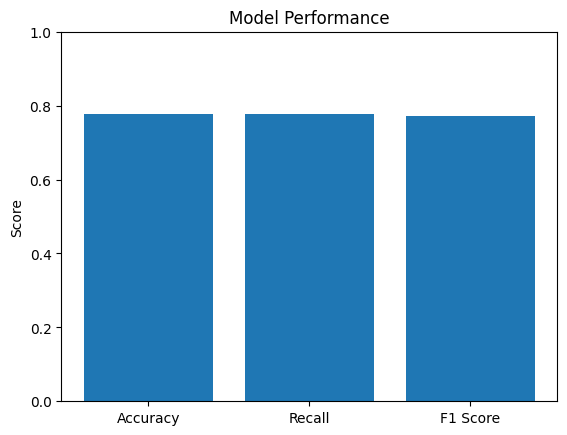

In [45]:
# Calculate accuracy, recall, and F1 score
accuracy = accuracy_score(y_test_labels, y_pred_labels)
recall = recall_score(y_test_labels, y_pred_labels, average='weighted')
f1 = f1_score(y_test_labels, y_pred_labels, average='weighted')

print("Accuracy:", accuracy)
print("Recall:", recall)
print("F1:", f1)

# Create a bar plot
labels = ['Accuracy', 'Recall', 'F1 Score']
values = [accuracy, recall, f1]

plt.bar(labels, values)
plt.ylim(0, 1)  # Set the y-axis limit to match the range of accuracy, recall, and F1 score
plt.title('Model Performance')
plt.ylabel('Score')
plt.show()

In [60]:
from sklearn.metrics import roc_auc_score, roc_curve
import numpy as np

# Make predictions on the test set
y_pred_prob = model.predict(X_test)

# Compute the ROC curve and AUC for each class
fpr = dict()
tpr = dict()
auc = dict()
for i in range(len(class_labels)):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred_prob[:, i])
    auc[i] = roc_auc_score(y_test[:, i], y_pred_prob[:, i])

# Plot the ROC curves
plt.figure()
for i in range(len(class_labels)):
    plt.plot(fpr[i], tpr[i], label='ROC curve (AUC = %0.2f)' % auc[i])

plt.plot([0, 1], [0, 1], 'k--')  # Plot the diagonal line (random classifier)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()



1/1 [==============================] - 0s 75ms/step


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed